In [1]:
from utils import *
from gwpy.segments import DataQualityFlag
import h5py
import gc
import matplotlib.pyplot as plt

# also imported from utils
import glob

In [2]:
data_times = [[1262878818.0, 1262878818.0 + 30*60, 'clean-event'], # 30 minutes clean data, with one event
              [1263103218.0, 1263103218.0 + 30*60, 'clean-no_event'], # 30 minutes clean data, no events
              [1262698440.0, 1262698440.0 + 30*60, 'dq-issues-1'], # 30 minutes mixed data, including glitches
              [1263225858.0, 1263225858.0 + 10*60, 'dq-issues-2'], # 10 minutes mixed data, including glitches
              [1262704578.0, 1262704578.0 + 20*60, 'dq-issues-3']] # 20 minutes mixed data, including glitches


In [3]:
files = glob.glob('DQSegments/O3B/*.hdf5')
files.sort(reverse=True)
dfs = []
for f in files:
    dfs.append(DataQualityFlag.read(f))

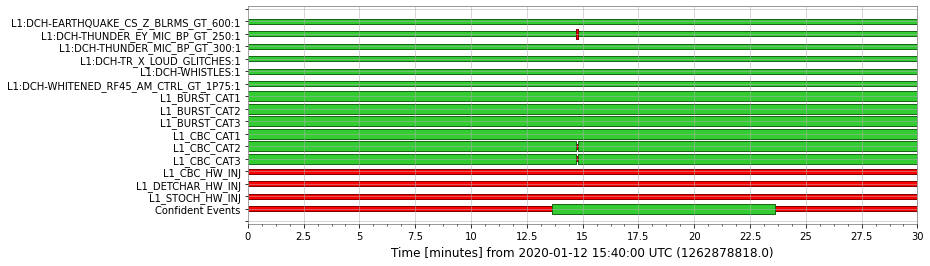

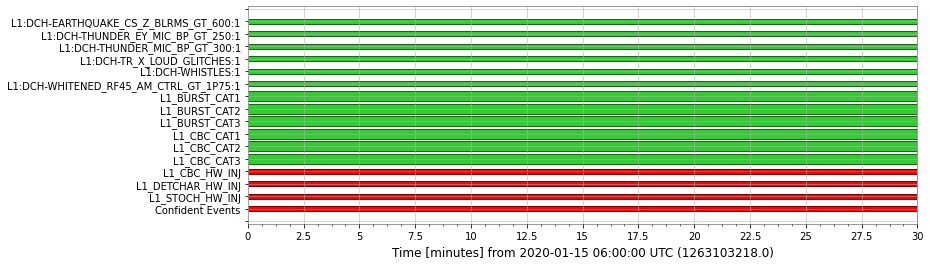

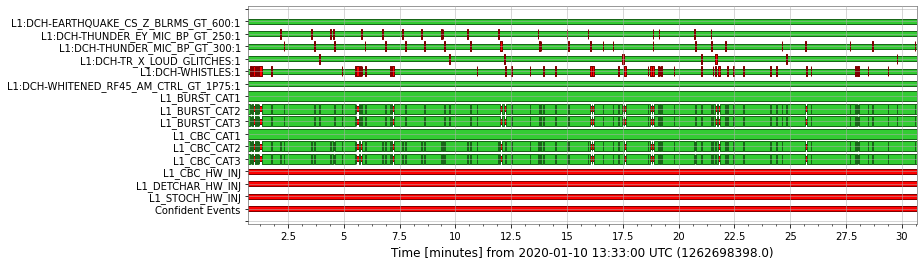

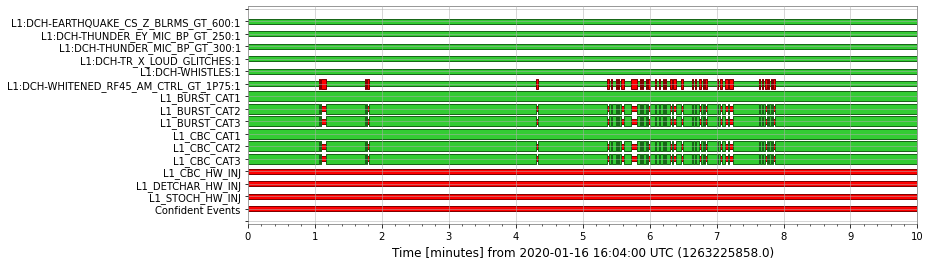

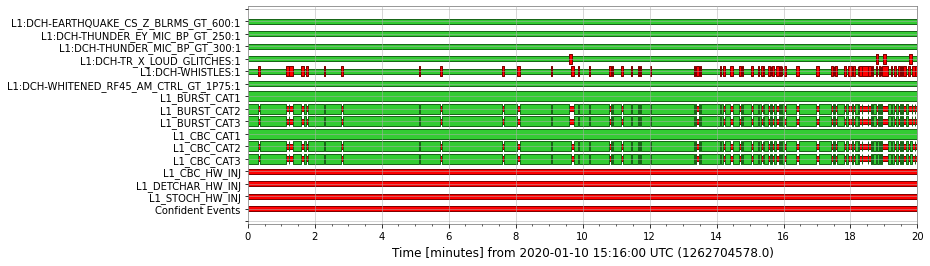

In [4]:
for [start, end, tag] in data_times:
    plot_dfs(dfs, start, end, save=f'DQF-Plots/{tag}')

In [3]:
# Download required the strain files from GWOSC
# [Can be deleted after the next cell]
strain_files = get_strain_files('O3b_16KHZ_R1', 'L1', np.asarray(data_times)[:,0], np.asarray(data_times)[:,1], padding=60)

Files to download: []
Download of O3b_16KHZ_R1-L1-1262878758-1262880678 complete
Files to download: []
Download of O3b_16KHZ_R1-L1-1263103158-1263105078 complete
Files to download: []
Download of O3b_16KHZ_R1-L1-1262698380-1262700300 complete
Files to download: []
Download of O3b_16KHZ_R1-L1-1263225798-1263226518 complete
Files to download: []
Download of O3b_16KHZ_R1-L1-1262704518-1262705838 complete


In [3]:
# Create hdf5 files for the strain for each stretch of time
for [start, end, tag] in data_times:
    create_datasets(int(float(start)), int(float(end)), data_prefix='L-L1_GWOSC_O3b_16KHZ_R1-', file_prefix=f'{tag}-', output_dir='strain_files/', padding=60)

In [2]:
strain_files = glob.glob('strain_files/*.hdf5')

In [5]:
# Slices the strain into segments and generates some features
# tthen saves it to file
output_dir = 'segment_files/'
for file in strain_files:
    print(f'reading {file}...')
    with h5py.File(f'./{file}', 'r') as f:
        strain = f['strain']['Strain'][:]
        epoch = f['strain']['Strain'].attrs['Xstart'][()]
        dt = f['strain']['Strain'].attrs['Xspacing'][()]
        padding = f['meta']['Padding'][()]

        meta_dict = {
            'Detector' : f['meta']['Detector'][()],
            'FrameType' : f['meta']['FrameType'][()],
            'StrainChannel' : f['meta']['StrainChannel'][()]
            }
        
        ##### Taken from readligo.py
        #-- Read the DQ information
        dqInfo = f['quality']['simple']
        qmask = dqInfo['DQmask'][...]
        shortnameArray = dqInfo['DQShortnames'][()]
        shortnameList  = list(shortnameArray)
        # -- Read the INJ information
        injInfo = f['quality/injections']
        injmask = injInfo['Injmask'][...]
        injnameArray = injInfo['InjShortnames'][()]
        injnameList  = list(injnameArray)

        channel_dict = {}  #-- 1 Hz, mask
        for flag in shortnameList:
            bit = shortnameList.index(flag)
            # Special check for python 3
            if isinstance(flag, bytes): flag = flag.decode("utf-8") 
            channel_dict[flag] = (qmask >> bit) & 1
        for flag in injnameList:
            bit = injnameList.index(flag)
            # Special check for python 3
            if isinstance(flag, bytes): flag = flag.decode("utf-8") 
            channel_dict[flag] = (injmask >> bit) & 1
        #####
    print('Processing...',end='\r')
    ts, ts_raw = process_strain(strain, epoch, dt, padding, sample_rate=4096)
    print('Making Segments...',end='\r')
    segs, segs_raw, segs_t, dq_flags, sample_rate = make_segments(ts, ts_raw, int(ts.sample_rate/10)+1, .5, channel_dict, padding)
    print('Saving Segments...',end='\r')
    file_name = file.split('/')[1].split('.')[0]
    save_segments(segs, segs_raw, segs_t, dq_flags, sample_rate, meta_dict, file_name, output_dir)
    print('Making Features...',end='\r')
    frac_dims, frac_dims_r, est_psds, psd_df, freq_bins, freq_bins_r = generate_features(segs, segs_raw, segs_t, sample_rate)
    print('Saving Features...',end='\r')
    with h5py.File(f'./{output_dir}{file_name}.hdf5', 'a') as f:
        features = f['data'].create_group('features')
        
        features['FractalDim'] = frac_dims
        features['FractalDimRaw'] = frac_dims_r
        features['EstimatedPSD'] = est_psds
        features['EstimatedPSD'].attrs.create('delta f', psd_df)
        features['FrequencyContent'] = freq_bins
        features['FrequencyContentRaw'] = freq_bins_r
    print('-------Done-------')
    del segs, segs_raw, segs_t, dq_flags, frac_dims, frac_dims_r, est_psds, freq_bins, freq_bins_r
    gc.collect()
    

reading strain_files/clean-event-1262878758.hdf5...
-------Done-------
reading strain_files/clean-no_event-1263103158.hdf5...
-------Done-------
reading strain_files/dq-issues-1-1262698380.hdf5...
-------Done-------
reading strain_files/dq-issues-2-1263225798.hdf5...
-------Done-------
reading strain_files/dq-issues-3-1262704518.hdf5...
-------Done-------


In [10]:
def descend_obj(obj,sep='\t'):
    """
    Iterate through groups in a HDF5 file and prints the groups, 
    datasets, and datasets attributes.

    Parameters
    ----------
    obj : hdf5 object, group or file
        The object to inspect.
    sep : str, optional
        Seperation string for printing the output. 
        The default is '\t'.

    Returns
    -------
    None.

    """
    if type(obj) in [h5py._hl.group.Group,h5py._hl.files.File]:
        for key in obj.keys():
            print(sep,'-',key,':',obj[key])
            descend_obj(obj[key],sep=sep+'\t')
    elif type(obj)==h5py._hl.dataset.Dataset:
        for key in obj.attrs.keys():
            print(sep+'\t','-',key,':',obj.attrs[key])

In [3]:
segment_files = glob.glob('segment_files/*.hdf5')

In [11]:
# shows the structure of the hdf5 files
with h5py.File(f'./{segment_files[0]}','r') as f:
    descend_obj(f['/'])

	 - data : <HDF5 group "/data" (4 members)>
		 - Epoch : <HDF5 dataset "Epoch": shape (35963,), type "<f8">
		 - RawStrain : <HDF5 dataset "RawStrain": shape (35963, 410), type "<f8">
		 - Strain : <HDF5 dataset "Strain": shape (35963, 410), type "<f8">
		 - features : <HDF5 group "/data/features" (5 members)>
			 - EstimatedPSD : <HDF5 dataset "EstimatedPSD": shape (35963, 206), type "<f8">
					 - delta f : 9.990243902439024
			 - FractalDim : <HDF5 dataset "FractalDim": shape (35963,), type "<f8">
			 - FractalDimRaw : <HDF5 dataset "FractalDimRaw": shape (35963,), type "<f8">
			 - FrequencyContent : <HDF5 dataset "FrequencyContent": shape (35963, 206), type "<f8">
			 - FrequencyContentRaw : <HDF5 dataset "FrequencyContentRaw": shape (35963, 206), type "<f8">
	 - dataquality : <HDF5 group "/dataquality" (12 members)>
		 - BURST_CAT1 : <HDF5 dataset "BURST_CAT1": shape (35963,), type "<u4">
		 - BURST_CAT2 : <HDF5 dataset "BURST_CAT2": shape (35963,), type "<u4">
		 - BURST_CAT3 : 

In [4]:
# read out some of the data
with h5py.File(f'./{segment_files[1]}','r') as f:
    sample_rate = f['meta']['SampleRate'][()]
    
    cbc_cat3 = f['dataquality']['CBC_CAT3'][:]
    cbc_cat2 = f['dataquality']['CBC_CAT2'][:]
    cbc_cat1 = f['dataquality']['CBC_CAT1'][:]
    burst_cat3 = f['dataquality']['BURST_CAT3'][:]
    burst_cat2 = f['dataquality']['BURST_CAT2'][:]
    burst_cat1 = f['dataquality']['BURST_CAT1'][:]
    
    
    fractal_dim = f['data']['features']['FractalDim'][:]
    fractal_dim_raw = f['data']['features']['FractalDimRaw'][:]
    
    epochs = f['data']['Epoch'][:]
    
    strain = f['data']['Strain'][:]
    #strainraw = f['data']['RawStrain'][:]
    
    psds = f['data']['features']['EstimatedPSD'][:]
    psd_df = f['data']['features']['EstimatedPSD'].attrs['delta f']
    
    freqcont = f['data']['features']['FrequencyContent'][:]
    #freqcont_raw = f['data']['features']['FrequencyContentRaw'][:]

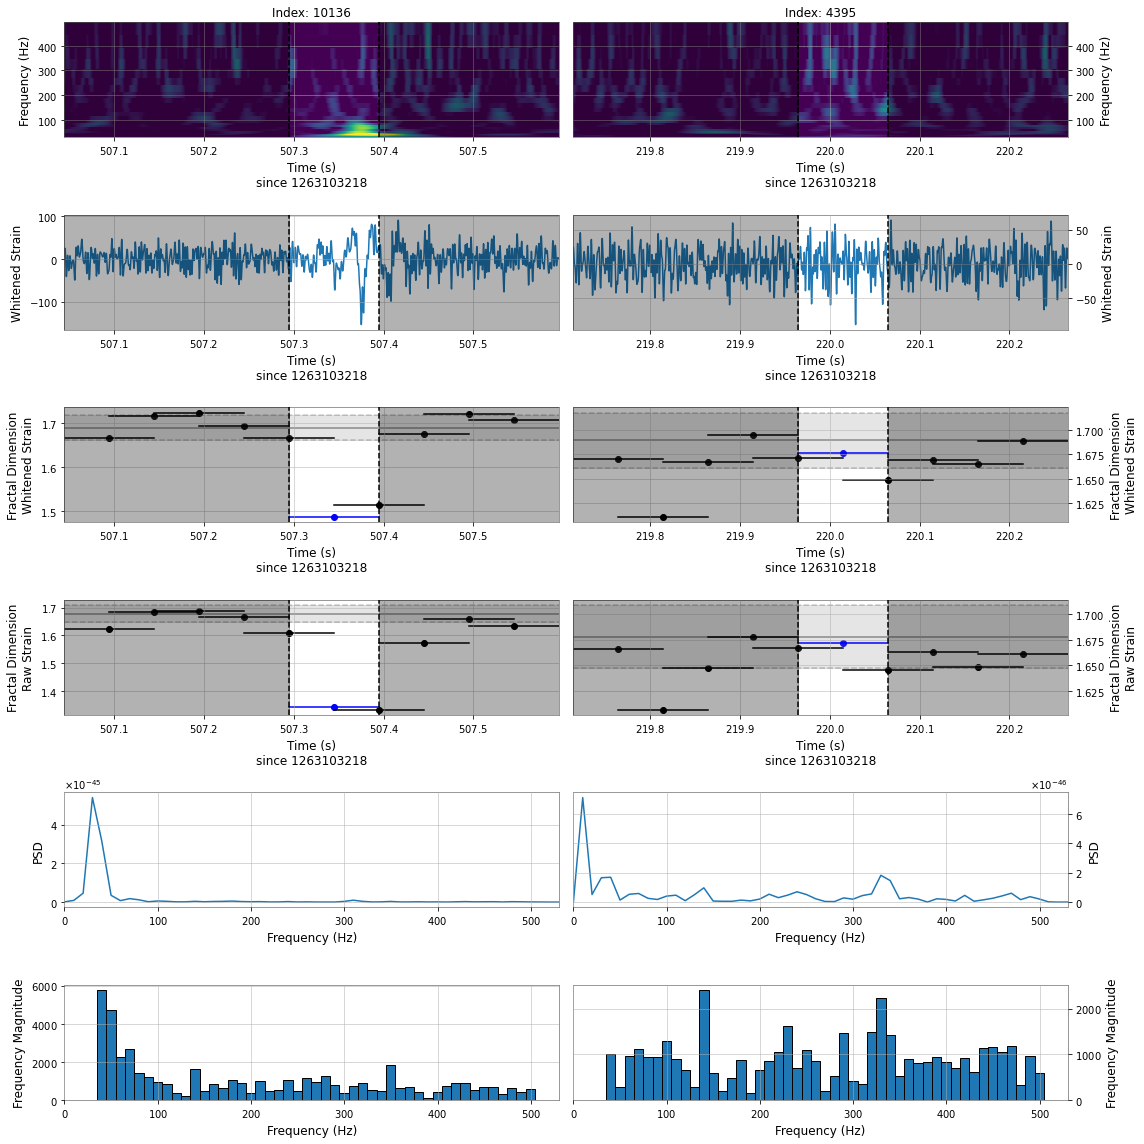

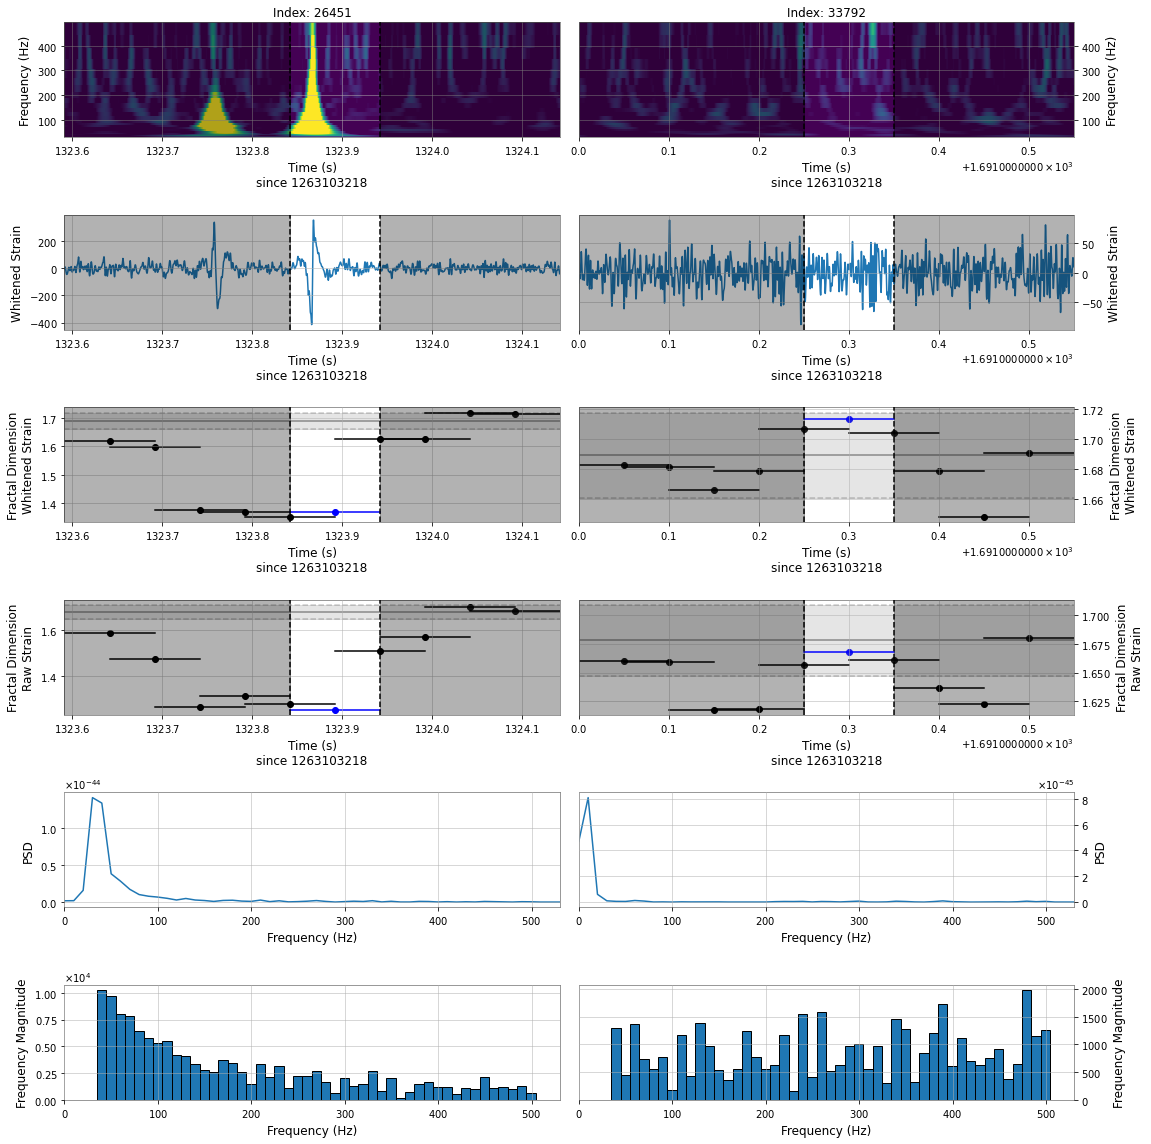

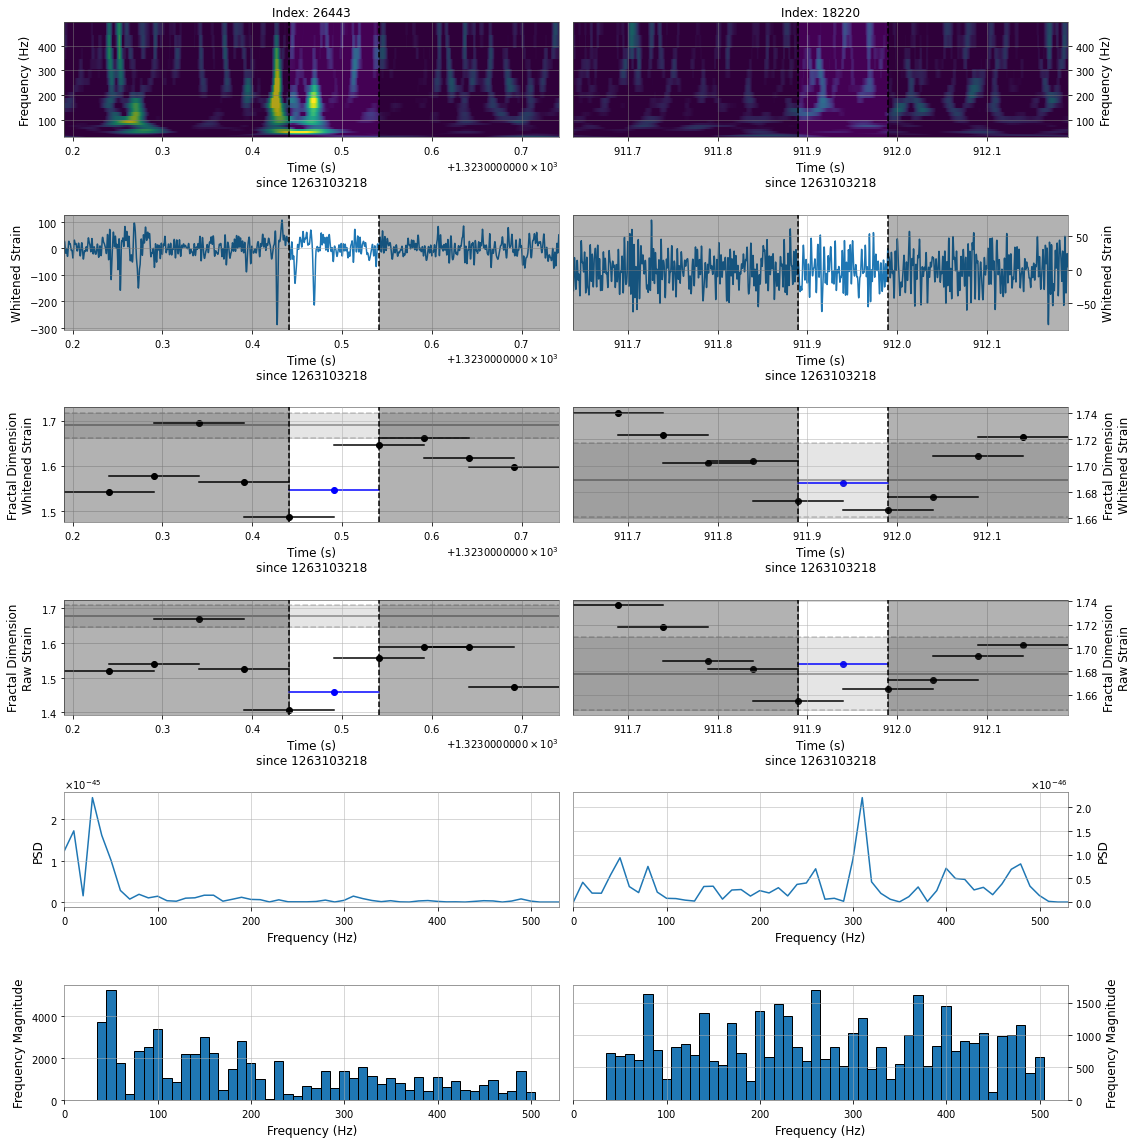

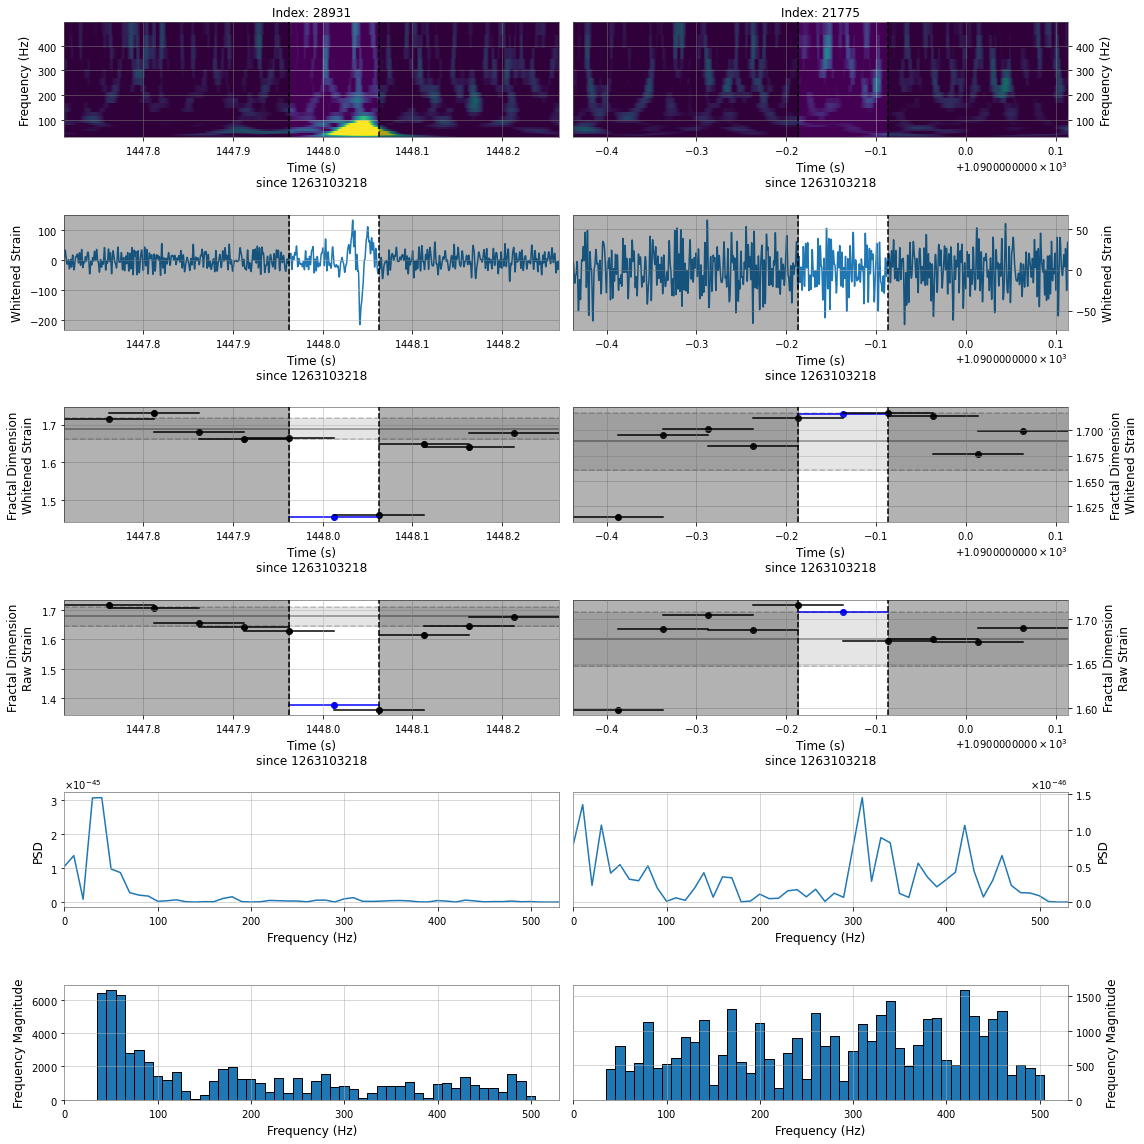

In [6]:
# plots some of the featurs for 4 segments with a fractal dimension 'close' to the mean and 4 'far away' from the mean
rand_idx1=np.random.choice(np.where(fractal_dim < 1.55)[0],4)
rand_idx2=np.random.choice(np.where(np.logical_and(fractal_dim>fractal_dim.mean()-fractal_dim.std(),fractal_dim<fractal_dim.mean()+fractal_dim.std()))[0],4)
x_freqs = np.arange(0,sample_rate/2+psd_df, psd_df)
times = epochs-epochs[0]
for i,j in zip(rand_idx1,rand_idx2):
    f,ax=plt.subplots(6,2, figsize=(16,16))
    
    psdi = psds[i]
    psdj = psds[j]
    freq_i = freqcont[i]
    freq_j = freqcont[j]
    si = strain[i-5:i+6,:205].flatten()
    sj = strain[j-5:j+6,:205].flatten()
    tis = times[i-5:i+6]
    tjs = times[j-5:j+6]
    tsi = pycbc.types.TimeSeries(si, delta_t=1/4096, epoch=float(tis[0]))
    tsj = pycbc.types.TimeSeries(sj, delta_t=1/4096, epoch=float(tjs[0]))
    
    ti = np.linspace(tis[0],tis[-1]+205/4096,len(si))
    tj = np.linspace(tjs[0],tjs[-1]+205/4096,len(sj))
    
    i_t, i_f, i_p = tsi.qtransform(1/4096,qrange=(8, 8),frange=(30, 500))
    j_t, j_f, j_p = tsj.qtransform(1/4096,qrange=(8, 8),frange=(30, 500))
    ax[0,0].pcolormesh(i_t,i_f,i_p**0.5,vmin=1,vmax=6)
    ax[0,1].pcolormesh(j_t,j_f,j_p**0.5,vmin=1,vmax=6)
    ax[0,0].set_xlabel(f'Time (s)\nsince {int(epochs[0])}')
    ax[0,1].set_xlabel(f'Time (s)\nsince {int(epochs[0])}')
    ax[0,0].set_ylabel('Frequency (Hz)')
    ax[0,1].set_ylabel('Frequency (Hz)')
    
    ax[1,0].plot(ti , si)
    ax[1,1].plot(tj , sj)
    ax[1,0].set_xlim(ti[0],ti[-1])
    ax[1,1].set_xlim(tj[0],tj[-1])
    ax[1,0].set_xlabel(f'Time (s)\nsince {int(epochs[0])}')
    ax[1,1].set_xlabel(f'Time (s)\nsince {int(epochs[0])}')
    ax[1,0].set_ylabel('Whitened Strain')
    ax[1,1].set_ylabel('Whitened Strain')
    
    for k, (fraci, fracj) in enumerate(zip(fractal_dim[i-5:i+5], fractal_dim[j-5:j+5])):
        cc = 'b' if k==5 else 'k'
        ax[2,0].plot([tis[k],tis[k]+410/4096], [fraci,fraci], cc)
        ax[2,1].plot([tjs[k],tjs[k]+410/4096], [fracj,fracj], cc)
        ax[2,0].scatter(tis[k]+205/4096, fraci,c=cc)
        ax[2,1].scatter(tjs[k]+205/4096, fracj,c=cc)
    
    ax[2,0].axhline(fractal_dim.mean(),c='k',alpha=0.4)
    ax[2,1].axhline(fractal_dim.mean(),c='k',alpha=0.4)
    ax[2,0].axhline(fractal_dim.mean()-fractal_dim.std(),c='k',alpha=.2,linestyle='--')
    ax[2,1].axhline(fractal_dim.mean()-fractal_dim.std(),c='k',alpha=.2,linestyle='--')
    ax[2,0].axhline(fractal_dim.mean()+fractal_dim.std(),c='k',linestyle='--',alpha=.2)
    ax[2,1].axhline(fractal_dim.mean()+fractal_dim.std(),c='k',linestyle='--',alpha=.2)
    ax[2,0].axhspan(fractal_dim.mean()-fractal_dim.std(),fractal_dim.mean()+fractal_dim.std(), color='grey', alpha=0.2)
    ax[2,1].axhspan(fractal_dim.mean()-fractal_dim.std(),fractal_dim.mean()+fractal_dim.std(), color='grey', alpha=0.2)
    
    ax[2,0].set_ylabel('Fractal Dimension\nWhitened Strain')
    ax[2,1].set_ylabel('Fractal Dimension\nWhitened Strain')
    
    ax[2,0].set_xlabel(f'Time (s)\nsince {int(epochs[0])}')
    ax[2,1].set_xlabel(f'Time (s)\nsince {int(epochs[0])}')
    
    for k, (fraci, fracj) in enumerate(zip(fractal_dim_raw[i-5:i+5], fractal_dim_raw[j-5:j+5])):
        cc = 'b' if k==5 else 'k'
        ax[3,0].plot([tis[k],tis[k]+410/4096], [fraci,fraci], cc)
        ax[3,1].plot([tjs[k],tjs[k]+410/4096], [fracj,fracj], cc)
        ax[3,0].scatter(tis[k]+205/4096, fraci,c=cc)
        ax[3,1].scatter(tjs[k]+205/4096, fracj,c=cc)
    
    ax[3,0].axhline(fractal_dim_raw.mean(),c='k',alpha=0.4)
    ax[3,1].axhline(fractal_dim_raw.mean(),c='k',alpha=0.4)
    ax[3,0].axhline(fractal_dim_raw.mean()-fractal_dim_raw.std(),c='k',alpha=.2,linestyle='--')
    ax[3,1].axhline(fractal_dim_raw.mean()-fractal_dim_raw.std(),c='k',alpha=.2,linestyle='--')
    ax[3,0].axhline(fractal_dim_raw.mean()+fractal_dim_raw.std(),c='k',linestyle='--',alpha=.2)
    ax[3,1].axhline(fractal_dim_raw.mean()+fractal_dim_raw.std(),c='k',linestyle='--',alpha=.2)
    ax[3,0].axhspan(fractal_dim_raw.mean()-fractal_dim_raw.std(),fractal_dim_raw.mean()+fractal_dim_raw.std(), color='grey', alpha=0.2)
    ax[3,1].axhspan(fractal_dim_raw.mean()-fractal_dim_raw.std(),fractal_dim_raw.mean()+fractal_dim_raw.std(), color='grey', alpha=0.2)
    
    ax[3,0].set_ylabel('Fractal Dimension\nRaw Strain')
    ax[3,1].set_ylabel('Fractal Dimension\nRaw Strain')
    
    ax[3,0].set_xlabel(f'Time (s)\nsince {int(epochs[0])}')
    ax[3,1].set_xlabel(f'Time (s)\nsince {int(epochs[0])}')
    
    
    ax[4,0].plot(x_freqs, psdi)
    ax[4,1].plot(x_freqs, psdj)
    ax[4,0].set_xlim(0,530)
    ax[4,1].set_xlim(0,530)
    ax[4,0].set_xlabel('Frequency (Hz)')
    ax[4,1].set_xlabel('Frequency (Hz)')
    ax[4,0].set_ylabel('PSD')
    ax[4,1].set_ylabel('PSD')
    
    mask = np.logical_and(x_freqs>=30, x_freqs<=500)
    ax[5,0].bar(x_freqs[mask], freq_i[mask], psd_df,linewidth=1,edgecolor='k')
    ax[5,1].bar(x_freqs[mask], freq_j[mask], psd_df,linewidth=1,edgecolor='k')
    ax[5,0].set_xlim(0,530)
    ax[5,1].set_xlim(0,530)
    ax[5,0].set_xlabel('Frequency (Hz)')
    ax[5,1].set_xlabel('Frequency (Hz)')
    ax[5,0].set_ylabel('Frequency Magnitude')
    ax[5,1].set_ylabel('Frequency Magnitude')
    
    ax[2,0].set_xlim(ax[1,0].get_xlim())
    ax[2,1].set_xlim(ax[1,1].get_xlim())
    ax[0,0].set_xlim(ax[1,0].get_xlim())
    ax[0,1].set_xlim(ax[1,1].get_xlim())
    ax[3,0].set_xlim(ax[1,0].get_xlim())
    ax[3,1].set_xlim(ax[1,1].get_xlim())
    
    
    for l in range(6):
        ax[l,1].yaxis.set_label_position("right")
        ax[l,1].yaxis.tick_right()
        if l < 4:
            ax[l,0].axvspan(tis[0],times[i], color='k',alpha=.3,zorder=5)
            ax[l,0].axvspan(times[i]+410/4096,tis[-1]+205/4096, color='k',alpha=.3,zorder=5)
            ax[l,0].axvline(times[i],color='k',linestyle='--',zorder=5)
            ax[l,0].axvline(times[i]+410/4096,color='k',linestyle='--',zorder=5)
            
            ax[l,1].axvspan(tjs[0],times[j], color='k',alpha=.3,zorder=5)
            ax[l,1].axvspan(times[j]+410/4096,tjs[-1]+205/4096, color='k',alpha=.3,zorder=5)
            ax[l,1].axvline(times[j],color='k',linestyle='--',zorder=5)
            ax[l,1].axvline(times[j]+410/4096,color='k',linestyle='--',zorder=5)
    
    
    ax[0,0].set_title(f'Index: {i}')
    ax[0,1].set_title(f'Index: {j}')
    
    plt.tight_layout()
    plt.show()